In [1]:
# Load datasets from saved pickle files
import pandas as pd
import os

import os, json, pickle, random, time

import xgboost as xgb
import numpy as np
from sklearn.preprocessing    import LabelEncoder
from sklearn.metrics          import (
    precision_recall_curve, auc,
    accuracy_score
)


In [2]:
def load_history(path):
    if os.path.exists(path):
        return pickle.load(open(path,'rb'))
    return {
        'tried_params': {},
        'best': {
            'params':     None,
            'pr_auc':     0.0,
            'acc_test':   0.0,
            'model_path': None
        }
    }

def save_history(history, path):
    d = os.path.dirname(path)
    if d and not os.path.exists(d):
        os.makedirs(d, exist_ok=True)
    pickle.dump(history, open(path,'wb'))

def sample_params(space, spw):
    return {
        'n_estimators':        random.randint(*space['n_estimators']),
        'learning_rate':       random.uniform(*space['learning_rate']),
        'max_depth':           random.randint(*space['max_depth']),
        'subsample':           random.uniform(*space['subsample']),
        'colsample_bytree':    random.uniform(*space['colsample_bytree']),
        'scale_pos_weight':    spw,
        'objective':           'binary:logistic',
        'eval_metric':         'aucpr',
        'random_state':        42,
        'early_stopping_rounds': 50
    }

def encode_and_spw(y_train):
    le   = LabelEncoder().fit(y_train)
    y_enc= le.transform(y_train)
    neg, pos = np.bincount(y_enc).max(), np.bincount(y_enc).min()
    return le, neg/pos

def train_and_pr(params, X_tr, y_tr, X_val, y_val):
    model = xgb.XGBClassifier(**params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    p_val = model.predict_proba(X_val)[:,1]
    prec, rec, _ = precision_recall_curve(y_val, p_val)
    return model, auc(rec, prec)

def test_acc(params, model, X_te, y_te):
    p_te = model.predict_proba(X_te)[:,1]
    return accuracy_score(y_te, (p_te>=0.5).astype(int))

def random_search_xgb_pr(
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    param_space,
    results_path,
    best_model_bin
):
    history = load_history(results_path)
    le, spw = encode_and_spw(y_train)
    y_tr   = le.transform(y_train)
    y_vale = le.transform(y_val)
    y_te   = le.transform(y_test)

    iteration = 0
    try:
        while True:
            iteration += 1
            params = sample_params(param_space, spw)
            key    = json.dumps(params, sort_keys=True)
            if key in history['tried_params']:
                continue

            # 1) train & get val PR‐AUC
            model, pr_val = train_and_pr(params,
                                         X_train, y_tr,
                                         X_val,   y_vale)
            # 2) measure test accuracy
            acc_te = test_acc(params, model, X_test, y_te)

            # record it
            history['tried_params'][key] = {
                'pr_val': pr_val,
                'acc_te': acc_te,
                'time':   time.time()
            }

            # 3) select if both pr_val ↑ and acc_te ≥ previous
            best = history['best']
            better_pr = pr_val > best['pr_auc']
            tie_pr    = pr_val == best['pr_auc']
            better_acc= acc_te > best['acc_test']
            not_worse_acc = acc_te >= best['acc_test']

            if (better_pr and not_worse_acc) or (tie_pr and better_acc):
                history['best'] = {
                    'params':     params,
                    'pr_auc':     pr_val,
                    'acc_test':   acc_te,
                    'model_path': best_model_bin
                }
                os.makedirs(os.path.dirname(best_model_bin) or '.', exist_ok=True)
                model.save_model(best_model_bin)
                print(f"[Iter {iteration}] 🎉 New best pr_val={pr_val:.4f}, acc_test={acc_te:.4f}")
                print("            params =", params)

            save_history(history, results_path)

    except KeyboardInterrupt:
        save_history(history, results_path)
        b = history['best']
        print("\n🔸 Interrupted — best so far:")
        print(f"   pr_val   = {b['pr_auc']:.4f}")
        print(f"   acc_test = {b['acc_test']:.4f}")
        print(f"   params   = {b['params']}")
        print(f"   model    = {b['model_path']}")

# ————————————————————————————————————————————————
# USAGE

PARAM_SPACE = {
    'n_estimators':     (20, 200),
    'learning_rate':    (0.01, 0.3),
    'max_depth':        (2, 30),
    'subsample':        (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
}

In [3]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, accuracy_score,
    roc_auc_score, roc_curve,
    precision_recall_curve, brier_score_loss, auc
)
from sklearn.calibration import CalibratedClassifierCV

def evaluate_model_stats(
    model: xgb.XGBClassifier,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    threshold: float = 0.5,
    calibrate: bool = True,
    calibrator_method: str = 'sigmoid'
):
    """
    Fit a LabelEncoder on y_train, optionally calibrate on (X_val, y_val),
    then compute & print metrics and show plots for raw vs. calibrated probabilities.
    
    Parameters
    ----------
    model
        A fitted XGBClassifier (pre-loaded with model.load_model()).
    X_train, y_train
        Training data / labels for refitting the label encoder.
    X_val, y_val
        Validation split for calibration (if calibrate=True).
    X_test, y_test
        Test split for final evaluation.
    threshold
        Probability threshold for converting to class labels.
    calibrate
        Whether to fit a CalibratedClassifierCV on (X_val, y_val).
    calibrator_method
        'sigmoid' or 'isotonic' (passed to CalibratedClassifierCV).
    """
    # --- 1) Label encoding ---
    le = LabelEncoder().fit(y_train)
    y_test_enc = le.transform(y_test)
    
    # --- 2) Calibration (optional) ---
    if calibrate:
        y_val_enc = le.transform(y_val)
        calibrator = CalibratedClassifierCV(
            estimator=model, method=calibrator_method, cv='prefit'
        )
        calibrator.fit(X_val, y_val_enc)
        proba = calibrator.predict_proba(X_test)[:, 1]
    else:
        proba = model.predict_proba(X_test)[:, 1]
    
    # --- 3) Metrics ---
    # Raw vs calibrated if you want both, but here we only use the final `proba`
    acc      = accuracy_score(y_test_enc, (proba >= threshold).astype(int))
    roc_auc  = roc_auc_score(y_test_enc, proba)
    brier    = brier_score_loss(y_test_enc, proba)
    
    print(f"Accuracy  @ t={threshold:.2f}: {acc:.4f}")
    print(f"ROC AUC          : {roc_auc:.4f}")
    print(f"Brier score      : {brier:.4f}\n")
    
    # --- 4) Confusion matrix ---
    y_pred = (proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, le.inverse_transform(y_pred),
                          labels=le.classes_)
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    plt.figure(figsize=(5,5))
    disp.plot(cmap='Blues', ax=plt.gca())
    plt.title(f'Confusion Matrix (t={threshold:.2f})')
    plt.show()
    
    # --- 5) Classification report ---
    print("Classification Report:")
    print(classification_report(
        y_test, le.inverse_transform(y_pred), target_names=le.classes_
    ))
    
    # --- 6) ROC curve ---
    fpr, tpr, _ = roc_curve(y_test_enc, proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.plot([0,1], [0,1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    # --- 7) Precision–Recall curve ---
    precision, recall, _ = precision_recall_curve(y_test_enc, proba)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, label=f"PR AUC={pr_auc:.3f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision–Recall Curve')
    plt.legend()
    plt.show()
    
    # --- 8) Feature importances ---
    plt.figure(figsize=(8,6))
    xgb.plot_importance(model, max_num_features=20)
    plt.title('Top 20 Feature Importances')
    plt.show()

In [4]:
# Check if files exist in the outputs directory
if os.path.exists('outputs/X_train_B.pkl'):
    # Load the required datasets for the model training
    X_train_B = pd.read_pickle('outputs/X_train_B.pkl')
    y_train_B = pd.read_pickle('outputs/y_train_B.pkl')
    X_val_B = pd.read_pickle('outputs/X_val_B.pkl')
    y_val_B = pd.read_pickle('outputs/y_val_B.pkl')
    X_test_B = pd.read_pickle('outputs/X_test_B.pkl')
    y_test_B = pd.read_pickle('outputs/y_test_B.pkl')
    
    print(f"Loaded datasets from pickle files:")
    print(f"X_train_B shape: {X_train_B.shape}")
    print(f"X_val_B shape: {X_val_B.shape}")
    print(f"X_test_B shape: {X_test_B.shape}")
    
    # Define paths for results
    RESULTS_PATH = 'outputs/xgb_pr_search_B.pkl'
    BEST_MODEL_BIN = 'outputs/xgb_pr_best_model_B.bin'
    
    # Now call the random search function with the loaded data
    random_search_xgb_pr(
        X_train_B, y_train_B,
        X_val_B, y_val_B,
        X_test_B, y_test_B,
        param_space=PARAM_SPACE,
        results_path=RESULTS_PATH,
        best_model_bin=BEST_MODEL_BIN
    )
else:
    print("Error: Dataset files not found in 'outputs/' directory.")
    print("Please ensure you've saved the datasets first using the to_pickle method.")

Loaded datasets from pickle files:
X_train_B shape: (12023, 217)
X_val_B shape: (6454, 217)
X_test_B shape: (6505, 217)


/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


[Iter 1] 🎉 New best pr_val=0.9791, acc_test=0.7772
            params = {'n_estimators': 76, 'learning_rate': 0.13928207750109642, 'max_depth': 3, 'subsample': 0.9278611009830304, 'colsample_bytree': 0.5018196372067862, 'scale_pos_weight': 2.698246693325131, 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'random_state': 42, 'early_stopping_rounds': 50}


/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


[Iter 3] 🎉 New best pr_val=0.9810, acc_test=0.7816
            params = {'n_estimators': 157, 'learning_rate': 0.140361055238723, 'max_depth': 4, 'subsample': 0.5978379759160509, 'colsample_bytree': 0.8616657202886135, 'scale_pos_weight': 2.698246693325131, 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'random_state': 42, 'early_stopping_rounds': 50}


/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:48:50] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


[Iter 14] 🎉 New best pr_val=0.9837, acc_test=0.7866
            params = {'n_estimators': 41, 'learning_rate': 0.11230222269306385, 'max_depth': 2, 'subsample': 0.7276311882501573, 'colsample_bytree': 0.8310083119351716, 'scale_pos_weight': 2.698246693325131, 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'random_state': 42, 'early_stopping_rounds': 50}

🔸 Interrupted — best so far:
   pr_val   = 0.9837
   acc_test = 0.7866
   params   = {'n_estimators': 41, 'learning_rate': 0.11230222269306385, 'max_depth': 2, 'subsample': 0.7276311882501573, 'colsample_bytree': 0.8310083119351716, 'scale_pos_weight': 2.698246693325131, 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'random_state': 42, 'early_stopping_rounds': 50}
   model    = outputs/xgb_pr_best_model_B.bin


Accuracy  @ t=0.90: 0.8787
ROC AUC          : 0.9172
Brier score      : 0.1452



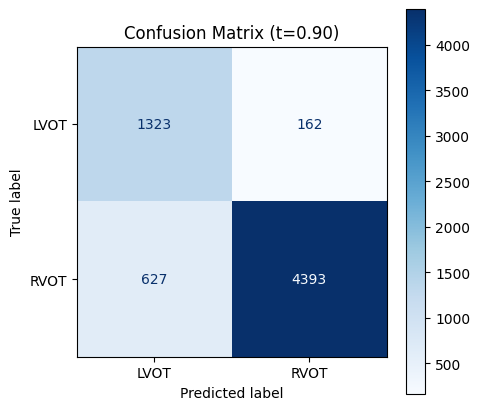

Classification Report:
              precision    recall  f1-score   support

        LVOT       0.68      0.89      0.77      1485
        RVOT       0.96      0.88      0.92      5020

    accuracy                           0.88      6505
   macro avg       0.82      0.88      0.84      6505
weighted avg       0.90      0.88      0.88      6505



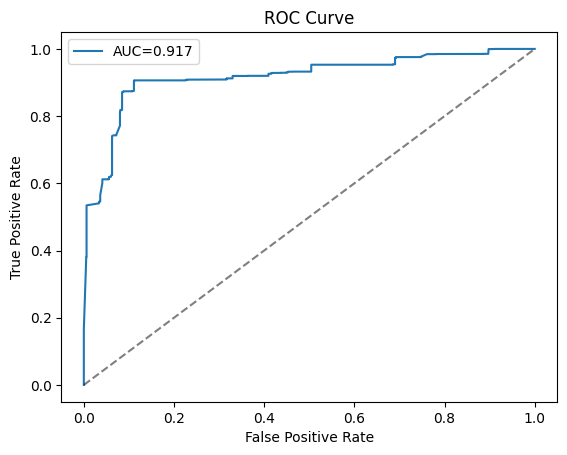

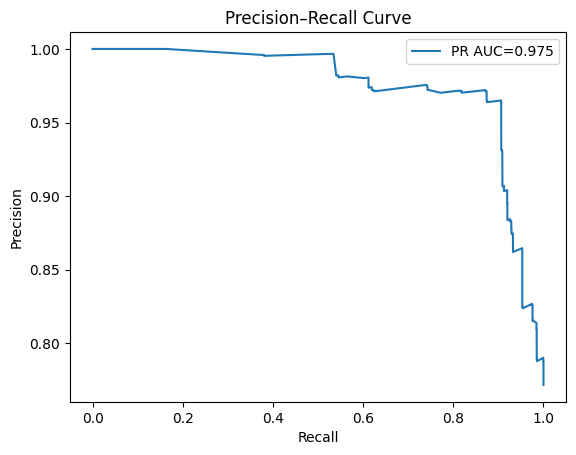

<Figure size 800x600 with 0 Axes>

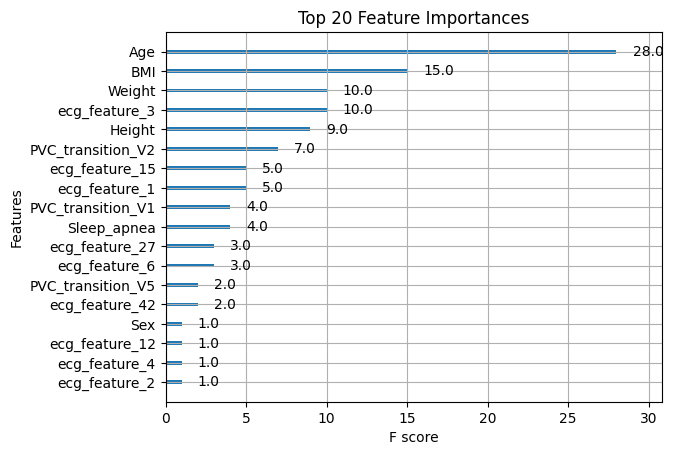

In [23]:
best_model = xgb.XGBClassifier()
best_model.load_model('outputs/xgb_pr_best_model_B.bin')

evaluate_model_stats(
    best_model,
    X_train_B, y_train_B,
    X_val_B,   y_val_B,
    X_test_B,  y_test_B,
    threshold=0.9,
    calibrate=True,
    calibrator_method='sigmoid'
)